# MA934  Numerical Methods - Workbook 2

In [1]:
using Plots
pyplot()
include("kvpair.jl")
include("llist.jl")
include("ftree.jl")
include("workbook2_function.jl");

## Question 1: Linear search using a linked list

<fontcolour = blue> {The file KVPair.jl defines a simple data structure to represent an (Int64, Float64) key-value pair. 

The file LList.jl defines a linked list that stores a KVPair at each node. Many languages have a keyword NULL. A pointer to any object can take the value NULL to indicate that it doesn't point to anything. NULL is often used to denote the end of a list, the leaves of a tree etc. Julia does not support NULL pointers. This causes a difficulty in implementing recursive data structures. Instead Julia provides a parametric data type Nullable{T} to represent missing values. It is possible to use Nullable types to define recursive data structures although some of the resulting definitions are a bit clumsy. I'm not sure that this is the canonical way to implement structural recursion in Julia. 

The following points are important:

* if a variable has type Nullable{T} then it can either contain a value of type T or nothing (ie a missing value). 
* the function isnull(x) checks whether a nullable type x has a value or not. 
* the function get(x) returns the actual value (of type T) contained in a nullable type x.

Much more information can be found at https://docs.julialang.org/en/stable/manual/types/

The function 

> buildLList(dataArray::Array{KVPair, 1})

takes an array of KVPair objects as input and returns an LList containing these KVPairs. This is illustrated in the code below.

1. Write a recursive function that traverses the list and prints out the key-value pairs stored in it. Check that your function works.
2. Write a function search(list::Nullable{LList}, k::Int64) that searches an LList for the key k and returns the corresponding KVPair if it is present and a Nullable{KVPair} otherwise. Verify that your function works.
3. Use Julia's @timed macro to measure how the typical computational cost of your search() function grows with the length of the list. }
</font>

$\textbf{Question 1.1}$:
Check that the recursive function keyvaluepairs works. This function inputs a list of any length and returns the KVPairs. We verify this function works for for a list of length N = 10.

In [2]:
#Question 1.1
#Check that recursive function keyvaluepairs works 
N = 10 #checks the function works for list of length N=10
seed = 3300
rng = MersenneTwister(seed)
X = rand(rng, N)
values = Array{KVPair}(N)
for i = 1:N #builds list
    values[i] = KVPair(i,X[i])
end

L = Nullable{LList}()
L = buildLList(values);

keyvaluepairs(L) #prints out KVPairs for a list of lenght N

KVPair(1, 0.9106712863152586)
KVPair(2, 0.4346829146136031)
KVPair(3, 0.38589111518347363)
KVPair(4, 0.9246032540129225)
KVPair(5, 0.6311166586789221)
KVPair(6, 0.8574998337247581)
KVPair(7, 0.961579117947865)
KVPair(8, 0.36612288307618823)
KVPair(9, 0.8202584768844892)
KVPair(10, 0.5197000283055662)


$\textbf{Question 1.2}$:
Check that the search function work. This function takes an input of a list and an integer value of the particular key that you want to find. It returns the associated the KVPair. In particular I check it works for the previous list (of length 10) and for the key value 4.

In [3]:
#Question 1.2
#check that search function works 
search(L, 4) #for list above it searches for the key value 4 and returns the KVPair

KVPair(4, 0.9246032540129225)

$\textbf{Question 1.3}$:
We measure the computational cost of the search function. I do this by averaging over the time the search function takes to find the assosiated KVPair for every key value of that list. I compute this for lists of length 1 to 500. We can observe that the computational time grows linearly with the length of the list.

In [4]:
#Question 1.3
times_mean = zeros(500) #lists of length up to 500
for i =1:500
    NN = i
    time = zeros(NN) #time temporaily stores the time taken to find every possible key value in that list
    XX = rand(rng, NN)
    VV = Array{KVPair}(NN) #generates a list of length NN 
    for l = 1:NN
        VV[l] = KVPair(l,XX[l])
    end
    LL = Nullable{LList}()
    LL = buildLList(VV)
    for k =1:NN
        time[k] = (@timed search(LL, k))[2]
    end
    times_mean[i] = mean(time) #mean time it takes to find any key value in a given list of length NN
end


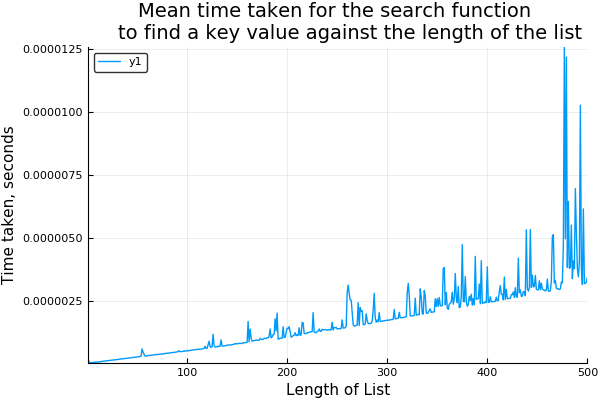

In [5]:
plot(1:500, times_mean,
    xlabel = "Length of List", 
    ylabel = "Time taken, seconds", 
    title = "Mean time taken for the search function 
    to find a key value against the length of the list"
)

<font color=blue>
It is interesting how the lower bound seems so perfectly linear. I'm still wondering what is going on here!
</font>

<font color=blue>
15/15
</font>

## Question 2: Interval membership

The problem of interval membership is the following: given a set of contiguous intervals, 

$\left\{[x_0, x_1), [x_1, x_2), \ldots, [x_{n-2}, x_{n-1}), [x_{n-1}, x_n)\right\}$

spanning the interval $[x_1, x_n)$ and given a random number $x \in [x_1, x_n)$, determine the interval in which $x$ lies. The standard numerical algorithm for stochastic simulation of continuous-time Markov processes (eg birth-death process, contact process, SIR model etc) requires solving an interval membership problem at each time step. It is therefore important to be able to solve it efficiently. Note, we cannot assume that all intervals are the same length.

We can solve the interval membership problem with $n$ interval by a variant of linear search in $O(n)$ time. We will demonstrate below that it can be solved in $O(\log\, n)$ time using a variant of a data structure known as a Fenwick tree.

**1)** Use Julia's random number generator to generate $n$ random interval lengths, $y_1, y_2, \ldots, y_n$ between 0 and 1 as shown: 

$\textbf{Question 2.1}$:
We generate a list with 10 intervals, each of lengths between 0 and 1 by taking the cumulative sum of each interval. We then use the function keyvaluepairs to print the KVPairs of this list.

In [6]:
n=10 #number of intervals
Y = rand(rng, n); #intervals each between 0 and 1

In [7]:
x = zeros(n)
for j = 1:n
    x[j] = sum(Y[1:j]) #finds the cumulative sum 
end

key_val = Array{KVPair}(n) #generates the linked list
for k = 1:n
    key_val[k] = KVPair(k,x[k])
end

Linked = Nullable{LList}()
Linked = buildLList(key_val)
keyvaluepairs(Linked) #prints the KVPairs of the list

KVPair(1, 0.5802578360807791)
KVPair(2, 1.300077582561761)
KVPair(3, 1.5244523773336254)
KVPair(4, 2.062447444257102)
KVPair(5, 3.026294762461893)
KVPair(6, 3.516416416020619)
KVPair(7, 4.375713341483044)
KVPair(8, 4.414019550760885)
KVPair(9, 4.552574082403461)
KVPair(10, 4.81141933748007)


The corresponding interval membership problem is constructed from the partial sums:
$$x_i = \sum_{j=1}^i y_j, \ \ \ \ \ i=1,2,\ldots n.$$ 
Using the objects defined in KVPair.jl and LList.jl, create an array of key-value pairs, $(i, x_i)$, associating each interval with the corresponding partial sum and store this array in a linked list. Print the list for a small value of $n$to verify that it works.

**2)** Modify the search function you wrote above to write a recursive function

$$\text{intervalmembership(list::Nullable{LList}, x::Float64)}$$

that takes the LList containing the list of partial sums and a random Float64 in the range $[0, x_n]$ as inputs and returns the KVPair corresponding to the interval in which $x$ lies. Verify that it works for small values of $n$ and use Julia's @timed macro to measure how the typical computational cost grows with $n$. 

**3)** The file FTree.jl defines a data structure implementing a variant of a Fenwick tree that can solve the interval membership problem as described in the lectures/notes. The function 

$$\text{buildFTree(T::Nullable{FTree}, dataArray::Array{KVPair, 1})}$$

takes the array of KVPairs containing the interval lengths as input, recursively constructs the tree and returns the FTree containing the correct key-value pairs (note a key of -1 is assigned to all non-leaf nodes).

$\textbf{Question 2.2}$:
We use the intervalmembership function with inputs a list of partial sums and an element $ x \in [0,x_n]$ where $x_n = \sum_{j=1}^{n} y_j$ is the total length of the interval we are interested in. intervalmembership function returns the KVPair this element lies in. In particular we test this function for the above list and for the value $x =4.2$.

In [8]:
intervalmembership(Linked,4.2) #for the above list returns the KVPair that x = 4.2 lies in

KVPair(7, 4.375713341483044)

We measure the computational cost of the function intervalmembership by averaging over the time the function takes to find 1000 values uniformally distributed from $[0, x_n]$. I do this for 13 lists of lengths $2^n$. Again we observe that this computational cost grows linearly with the length of the list. 

In [9]:
timed = zeros(13) #finds the time taken for intervalmembership to run for lists of sizes 2^0 to 2^{12}
for i = (0:12)
    nn = 2.^(i)
    time_1 = zeros(nn)
    yy = rand(rng, nn)
    xx = cumsum(yy)
    kval = Array{KVPair}(nn)
    for k = 1:nn
        kval[k] = KVPair(k,xx[k])
    end
    ll = Nullable{LList}()
    ll = buildLList(kval)
    x_nn = search(ll, nn).value #finds the last value of the list as this is the interval [0,x_nn]
    for j = 1:nn
        for k in linspace(0.0, x_nn, 1000) #runs program for 1000 values between [0,1000]
            time_1[j]= (@timed intervalmembership(ll, k))[2]
        end
    end
    timed[i+1] = mean(time_1)
end



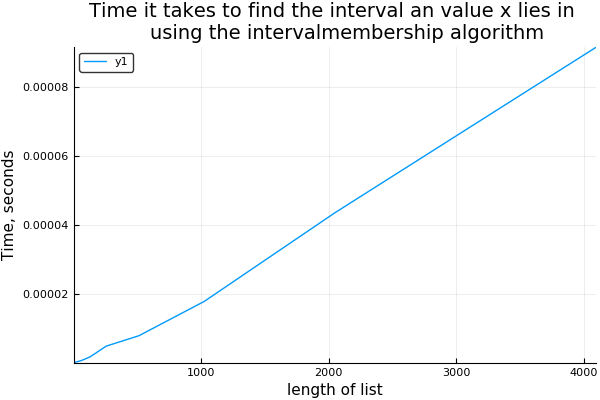

In [10]:
plot(2.^(0:12), timed,
    ylabel = "Time, seconds", 
    xlabel = "length of list",
    title = "Time it takes to find the interval an value x lies in 
    using the intervalmembership algorithm"
)

<font color=blue>
It would be neater to plot the numerical data points as well as the lines joining them. Also your legend should have something more informative than y1.
</font>

Write a recursive function

$$\text{intervalmembership(FT::Nullable{FTree}, x::Float64)}$$

that takes the FTree containing the list of partial sums and a random Float64 in the range $[0, x_n]$ as 
inputs and returns the KVPair corresponding to the interval in which $x$ lies. Verify that it works for small values of $n$ and use Julia's @timed macro to compare how the typical computational compares to the above linear search version. Note it can sometimes be difficult to directly measure $O(\log\, n)$ growth in computation time since the problem size needs to become very large to register appreciable run times.

$\textbf{Question 2.3}$:
We generate a Fenwick tree of with 5 leaves, each corresponding to an subinterval. We test that the function intervalmembership1 which inputs a tree and an element $x \in [0,x_n]$ and will return the KVPair of which subinterval this element lies in. In particular I test that the intervalmembership1 function works for a tree with 5 subintervals   and the element $x=1.2$.

Again we compute the computational cost of the Fenwick tree algorithm to find the interval membership. We know from class the computational cost should grow with $n$ intervals with $\mathcal{O}(\log(n))$. I compute the computational cost for 13 Fenwick trees with length $2^n \ \text{for} \ n=0,...,12$ and find the average time to find the subinterval for 1000 elements, $x \in [0,x_n]$. We use a log scale on the x-axis to observe this analytical computational cost matches the numerical computation.

In [11]:
n=5
X = rand(rng, n)
values = Array{KVPair}(n)
for i = 1:n #for trees we DON'T input the cumulative frequency
    values[i] = KVPair(i,X[i])
end
T = Nullable{FTree}(FTree(KVPair(0,0.0))) #builds the tree
T=buildFTree(T, values);

In [12]:
# test function
intervalmembership1(T, 1.2) #uses a Fenwick tree to find the interval x=1.2 lies in

KVPair(2, 0.8686215937439714)

In [13]:
timed_2 = zeros(13)
for i = (0:12) #again uses 2^i for the length of each interval
    nn = 2.^(i)
    time_2 = zeros(nn)
    yy2 = rand(rng, nn)
    y_nn=sum(yy2) #maximum of the interval [0,y_nn]
    kval2 = Array{KVPair}(nn)
    for k = 1:nn
        kval2[k] = KVPair(k,yy2[k])
    end
    tt = Nullable{FTree}(FTree(KVPair(0,0.0)))
    tt =buildFTree(tt, kval2)
    for j = 1:nn
        for k in linspace(0.0, y_nn, 1000)
            time_2[j]= (@timed intervalmembership1(tt, k))[2]
        end
    end
    timed_2[i+1] = mean(time_2)
end


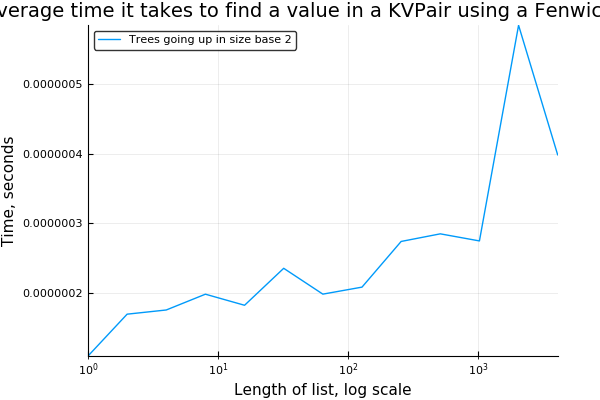

In [14]:
plot(2.^(0:12), timed_2, 
    yaxis = :none, 
    xaxis = :log, 
    ylabel = "Time, seconds", 
    xlabel = "Length of list, log scale",
    title = "Average time it takes to find a value in a KVPair using a Fenwick Tree", 
    label = "Trees going up in size base 2"
)

<font color=blue>
This would also be nicer with the points on. Good answer overall though.
</font>

<font color=blue>
14/15
</font>

## Question 3: Gillespie algorithm for heterogeneous diffusion

The Gillespie algorithm is a dynamic Monte Carlo algorithm that generates statistically correct realisations of a continous time Markov process. See https://en.wikipedia.org/wiki/Gillespie_algorithm It is used heavily in stochastic simulation of chemical and biological reaction networks and population dynamics. In this question we use it to simulate one-dimensional diffusion of heterogeneous particles whose diffusion constants are independently drawn from an exponential distribution.

The basic idea of the algorithm is as follows
1. Create a list $\left\{(i, r_i), i=1,\ldots M\right\}$,  of all possible transitions (events), $i$, that can occur in the system and the corresponding transition rates, $r_i$.
2. Calculate the total rate
$$R = \sum_{i=1}^M r_i$$
and divide the interval $[0, R]$ into $M$ intervals whose lengths are given by the $r_i$.
3. Generate a uniform random number in the range $[0,R]$ and determine which interval it falls in. 
4. Perform the corresponding transition and update the time variable by an amount $\Delta t = 1/R$.
5. Repeat until the desired simulation time is reached.

To be concrete, suppose with have $N$ particles on the interval $[-L, L]$ initially located at $x=0$. Each particle can hop a distance $\Delta x$ to the left or to the right with equal probability. The rate of hopping is initially considered to be the same for all particles:

$$ r_i = \frac{D}{2}\,\frac{1}{(\Delta x)^2} $$

This choice ensures that in the continous limit ($\Delta x \to 0$, $N\to \infty$), the density of particles $c(x,t)$ on the line will satisfy the usual diffusion equation with diffusion coefficient $D$ (recall MA933):

$$ \frac{\partial c}{\partial t} = D \frac{\partial^2 c}{\partial x^2}$$

with initial condition $c(x,0) = \delta(x)$.

The steps of the algorithm then correspond to the following:
1. There are $M= 2 N$ possible transitions at each step: each of $N$ particles can hop a distance $\Delta x$ either left or right with the above rates. We index them as follows: events k=1:N correspond to particle k hopping to the right, events k=N+1:2N correspond to particle k-N hopping to the left.
2. The total rate is 
$$ R = \frac{D N}{(\Delta x)^2}.$$
3. Generate a uniform random number in the range $[0,R]$ and determine the index $k$ of particle to move and the direction.
4. Update the position of particle $k$ accordingly.
5. Repeat.

The following piece of code implements the Gillespie algorithm for N=100, L=10, $\Delta x = 0.1$ and $D=1$, converts the particle positions to particle density and compares to the solution of the diffusion equation on an unbounded domain at t=1 (we assume that L=10 is far enough from zero to be considered unbounded):

$$c(x, t) = \frac{1}{\sqrt{2 \pi D t}}\, \exp [-\frac{1}{2}\frac{x^2}{D t} ]$$


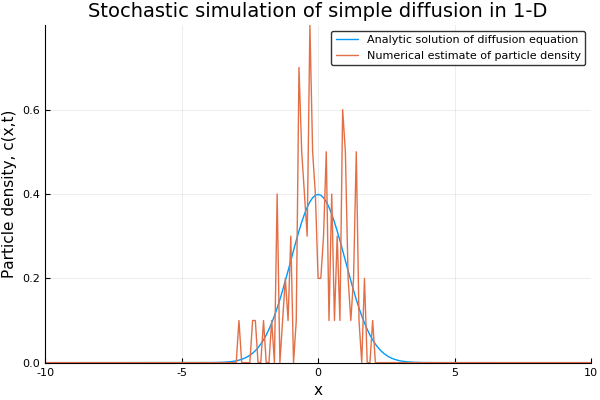

In [15]:
L=10.0
N=100
Nx = 201
dx = 2.0*L/(Nx-1)
X = dx.*(-(Nx-1)/2:(Nx-1)/2)
Y =zeros(Int64,N) #initially all particles are at N, this will be filled with their states (integers)
D = 1.0
t=0.0

r = (D)./(2.0*dx*dx)
totalRate = 2.0*N*r
dt = 1.0/totalRate
T=1.0

# This is the main loop
while t < T
    # Pick an event
    k = rand(1:2*N) 
    if k<=N
        hop = 1
        particleId = k
    else
        hop = -1
        particleId=k-N
    end
    Y[particleId]+=hop
    t+=dt
end

# Calculate the estimated density of particles
P =zeros(Float64,length(X))
for i in 1:length(Y)
    P[Y[i]+Int64((Nx-1)/2)+1]+=1/(N * dx)
end

# Calculate the theoretical density and compare
function normal(x, D, t)
    return (1.0/sqrt(2.0*pi*D*t))*exp(-x*x/(2*D*t))
end
P1 = normal.(X, D, T)
plot(X, P1, label="Analytic solution of diffusion equation")
plot!(X, P, label="Numerical estimate of particle density")
xlabel!("x")
ylabel!("Particle density, c(x,t)")
title!("Stochastic simulation of simple diffusion in 1-D")

**1)** The code above makes critical use of the fact that all intervals have the same width in order to decide which particle to move at each step. Suppose now that instead of being equal to $D$ for each particle, the diffusion coefficients are drawn from an exponential distribution with mean $D$:

$$ P(x) = \frac{1}{D} \exp\left(-\frac{x}{D}\right). $$

Modify the code to account for this, using your code from Q2 above to solve the interval membership problem using linear search. You will need to use Julia's randexp() function to generate values for the diffusion coefficients. What is the largest value of $N$ you can simulate in a "reasonable" time?

**2)** Try again using your Fenwick tree from Q2 to solve the interval membership problem and compare. What is the largest value of $N$ you can simulate now?

**3)** Show analytically that the solution of the heterogenous diffusion problem is

$$ c(x,t) = \frac{\exp \left(-\sqrt{\frac{2}{D\,t}}\, |x| \right)}{\sqrt{2\, D\, t}}$$

You will probably need the integral formula (Formula 3.325 of Gradshteyn and Rizhik, 7th Ed.)

$$ \int_0^\infty \exp\left(-a\,x^2 - \frac{b}{x^2} \right)\, dx =  \frac{1}{2}\,\sqrt{\frac{\pi}{a}}\,\exp\left(-2 \sqrt{a\,b} \right).$$
Use this formula to validate your numerical results.



time to run = 1.864619488 seconds for N = 1000



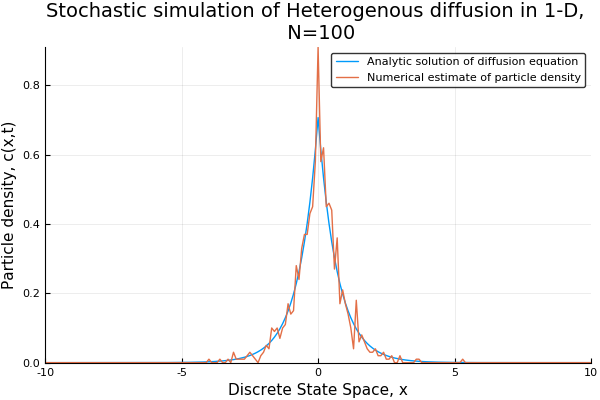

In [16]:
#Question 3.1
D_mean = 1
T_time = 1
N_particles = 1000
State_space = 201
X, P = gillelist(N_particles, State_space, 10, D_mean, T_time)

P2 = hetergenousdiffusion.(X, D_mean, T_time)

println("time to run = $((@timed gillelist(N_particles,State_space,10,D_mean,T_time))[2]) seconds for N = $N_particles")
plot(X, P2, 
    label="Analytic solution of diffusion equation",
    title = "Stochastic simulation of Heterogenous diffusion in 1-D, \n N=100",
    xlabel = "Discrete State Space, x",
    ylabel = "Particle density, c(x,t)"
)
plot!(X, P, 
    label="Numerical estimate of particle density"
)

In [17]:
lengths = zeros(13)
for j =0:12 #lengths of size 2^n
    lengths[j+1] = 2^j
end

times = zeros(13)
for k = 1:13
    N = Int(lengths[k])
    times[k] = (@timed gillelist(N, State_space, 10, D_mean, T_time))[2] #returns the time to compute the function sortarray
end


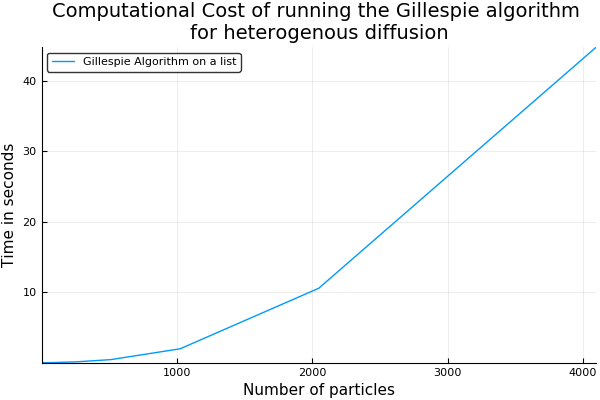

In [18]:
plot(lengths, times, 
    label = "Gillespie Algorithm on a list", 
    xlabel = "Number of particles",
    ylabel = "Time in seconds",
    title = "Computational Cost of running the Gillespie algorithm \nfor heterogenous diffusion"
)

time to run = 18.583956939 seconds for N = 100000



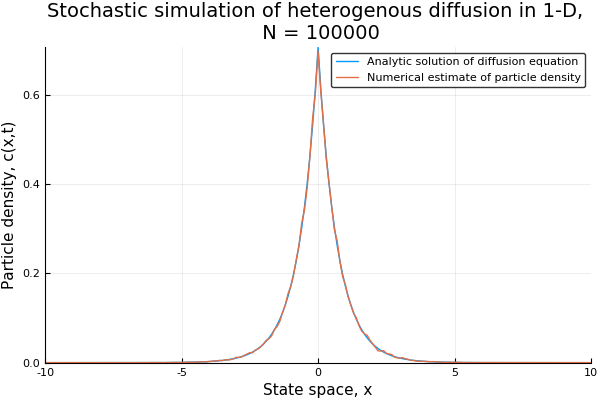

In [19]:
#Question 3.2
N_particless = 100000
X1, P1 = fenwick_gillespie(N_particless, State_space, 10, D_mean, T_time)
P3 = hetergenousdiffusion.(X1, D_mean, T_time)
println("time to run = $((@timed fenwick_gillespie(N_particless,State_space,10,D_mean,T_time))[2]) seconds for N = $N_particless")
plot(X1, P3,
    label="Analytic solution of diffusion equation",
    xlabel = "State space, x",
    ylabel = "Particle density, c(x,t)",
    title = "Stochastic simulation of heterogenous diffusion in 1-D, \n N = $N_particless"
)
plot!(X1, P1,
    label="Numerical estimate of particle density"
)

In [20]:
lengths1 = zeros(20)
for j =0:19 #lengths of size 2^n
    lengths1[j+1] = 2^j
end

times1 = zeros(20)
for k = 1:20
    N1= Int(lengths1[k])
    times1[k] = (@timed fenwick_gillespie(N1, State_space, 10, D_mean, T_time))[2] #returns the time to compute the function sortarray
end

LoadError: [91mBoundsError: attempt to access 201-element Array{Float64,1} at index [205][39m

<font color=blue>
I got an out of bounds error when I ran this bit of code - never mind. Measuring the performance as a function of N is a bit tangential to the question.
</font>

In [ ]:
plot(lengths1, times1, 
    label = "Gillespie Algorithm on a Fenwick Tree", 
    xlabel = "Number of particles",
    ylabel = "Time in seconds",
    title = "Computational Cost of running the Gillespie algorithm \nfor heterogenous diffusion"
)

$\textbf{Question 3.3}$:

Now D is a random exponentially distributed variable. Then each particle will satisfy the homogenous equation $$\frac{\partial c(x,t)}{\partial t} = D \frac{\partial^2 c(x,t)}{\partial x^2}$$ Where $D \sim \frac{exp(-\frac{y}{\lambda})}{\lambda} $ is exponentially distributed with mean $\lambda = 1$. We can say the solution to the heterogenous diffusion problem is the expected value over all particles of the homogenous diffusion solution with the random variable D: $$<c(x,t)> = \int_{0}^{\infty} dy \frac{1}{D} e^{-\frac{y}{D}} \left( \frac{1}{\sqrt{2 \pi y t}} exp({-\frac{x^2}{2yt}})\right) $$
Then using the subsitution $y = z^2$, $$<c(x,t)> = \frac{2}{D \sqrt{2 \pi t}} \int_{0}^{\infty} dz \ z \ z^{-1} exp({-\frac{z^2}{D}-\frac{x^2}{2z^2t}) }.$$ Then by the above formula,  $<c(x,t)> = \frac{1}{ \sqrt{2 D t}}  exp({-\frac{2 |x|}{\sqrt{2Dt}}})$.

<font color=blue>
Very good answer.
</font>

<font color=blue>
15/15
</font>